In [0]:
import numpy 
print(numpy.__version__)

1.14.6


In [0]:
import matplotlib 
print(matplotlib.__version__)

2.1.2


In [0]:
import PIL 
print(PIL.__version__)

4.0.0


In [0]:
import tensorflow 
print(tensorflow.__version__)

1.12.0


In [0]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,15)
mpl.rcParams['axes.grid'] = False

import numpy as np
import time

In [0]:
from PIL import Image
from tensorflow.python.keras import preprocessing

def load_img(path_to_img):
    img = Image.open(path_to_img) 
    long = max(img.size) 
    max_dim = 512
    scale = max_dim/long
    img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS) 
    img = preprocessing.image.img_to_array(img) 
    img = np.expand_dims(img, axis=0)
    return img
  
  
def imshow(img, title): 
    out_img = np.squeeze(img, axis=0)
    plt.title(title)
    plt.imshow(out_img)

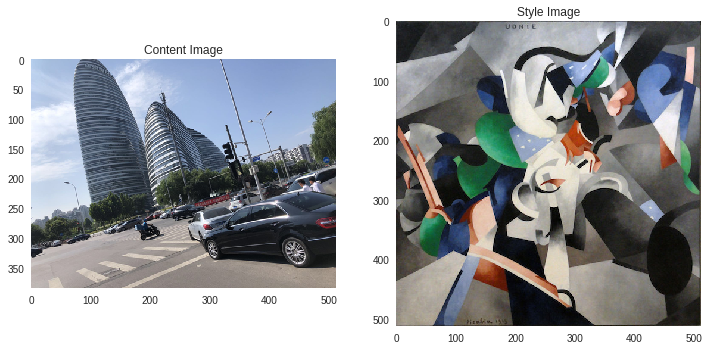

In [0]:
style_path = "udnie.jpg"  
content_path = "wangjing_selfie.jpg"
 
plt.subplot(1, 2, 1)
p_img = load_img(content_path).astype('uint8')
imshow(p_img, "Content Image")
 
plt.subplot(1, 2, 2)
p_img = load_img(style_path).astype('uint8')
imshow(p_img, "Style Image")

In [0]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe

from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K
 
tf.enable_eager_execution()
print("Eager execution: {}".format(tf.executing_eagerly()))

Eager execution: True


In [0]:
def load_and_process_img(path_to_img): 
    img = load_img(path_to_img) 
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

In [0]:
def deprocess_img(processed_img): 
    x = processed_img.copy() 
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    assert len(x.shape) == 3, ("输入的反转处理图像维度必须是[1, height, width, channel]或者[height, width, channel]")
    if len(x.shape) != 3:
        raise ValueError("无效的图像！") 
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68 
    x = x[:, :, ::-1] 
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [0]:
content_layers = ['block5_conv2']  
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [0]:
def get_model(): 
    vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    style_outputs = [vgg.get_layer(name).output for name in style_layers]
    content_outputs = [vgg.get_layer(name).output for name in content_layers]
    model_outputs = style_outputs + content_outputs
    return models.Model(vgg.input, model_outputs)

In [0]:
def get_content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

In [0]:
def gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

def get_style_loss(base_style, gram_target):
    height, width, channels = base_style.get_shape().as_list()
    gram_style = gram_matrix(base_style)
    return tf.reduce_mean(tf.square(gram_style - gram_target)) 

In [0]:
def get_feature_representations(model, content_path, style_path):  
    content_image = load_and_process_img(content_path)
    style_image = load_and_process_img(style_path) 
    
    style_outputs = model(style_image)
    content_outputs = model(content_image) 
    
    style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
    content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
    return style_features, content_features

In [0]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    style_weight, content_weight = loss_weights
 
    model_outputs = model(init_image)

    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers:]

    style_score = 0
    content_score = 0
 
    weight_per_style_layer = 1.0 / float(num_style_layers)
    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
 
    weight_per_content_layer = 1.0 / float(num_content_layers)
    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)

    style_score *= style_weight
    content_score *= content_weight
 
    loss = style_score + content_score 
    return loss, style_score, content_score

In [0]:
def compute_grads(cfg):
    with tf.GradientTape() as tape: 
        all_loss = compute_loss(**cfg)
    total_loss = all_loss[0]
    return tape.gradient(total_loss, cfg['init_image']), all_loss

In [0]:
model = get_model() 
for layer in model.layers:
    layer.trainable = False

style_features, content_features = get_feature_representations(model, content_path, style_path)
gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

init_image = load_and_process_img(content_path)
init_image = tfe.Variable(init_image, dtype=tf.float32)
opt = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)

best_loss, best_img = float('inf'), None

style_weight = 1e-2
content_weight = 1e3
loss_weights = (style_weight, content_weight)
cfg = {
    'model': model,
    'loss_weights': loss_weights,
    'init_image': init_image,
    'gram_style_features': gram_style_features,
    'content_features': content_features
}

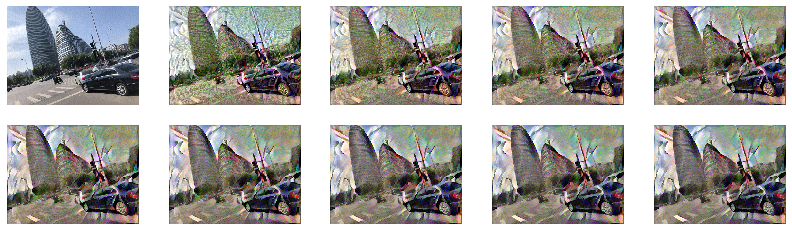

In [0]:
import IPython.display 

num_iterations = 1000
num_rows = 2
num_cols = 5
display_interval = num_iterations/(num_rows*num_cols)
start_time = time.time()
global_start = time.time()
norm_means = np.array([103.939, 116.779, 123.68])
min_vals = -norm_means
max_vals = 255 - norm_means   

imgs = []
for i in range(num_iterations):
    grads, all_loss = compute_grads(cfg)
    loss, style_score, content_score = all_loss
    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    end_time = time.time() 

    if loss < best_loss:
        best_loss = loss
        best_img = deprocess_img(init_image.numpy())

    if i % display_interval== 0:
        start_time = time.time()
        plot_img = init_image.numpy()
        plot_img = deprocess_img(plot_img)
        imgs.append(plot_img)
        IPython.display.clear_output(wait=True)
        IPython.display.display_png(Image.fromarray(plot_img))
        print('Iteration: {}'.format(i))        
        print('Total loss: {:.4e}, ' 
              'style loss: {:.4e}, '
              'content loss: {:.4e}, '
              'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
print('Total time: {:.4f}s'.format(time.time() - global_start))

IPython.display.clear_output(wait=True)
plt.figure(figsize=(14,4))
for i,img in enumerate(imgs):
    plt.subplot(num_rows,num_cols,i+1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

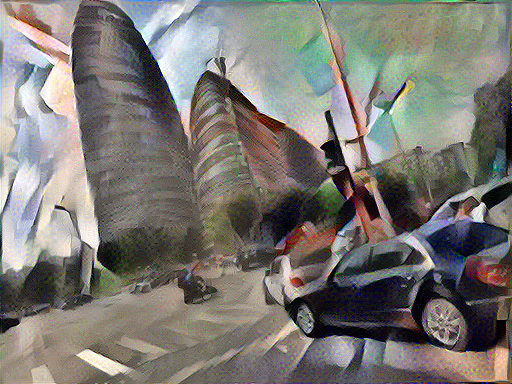

In [0]:
Image.fromarray(best_img)

In [0]:
from PIL import Image
import numpy as np

width = 512
height = 512

def load_img(filepath):
    img = Image.open(filepath)
    img = img.resize((width, height))
    arr = np.asarray(img, dtype=np.float32)
    img_arr = np.expand_dims(arr, axis=0)
    return img_arr
  
content_path = "xiangshan.jpeg"
style_path = "the_shipwreck_of_the_minotaur.jpg" 
style_image = load_img(style_path)
content_image = load_img(content_path)
print("content_image.shape={}, style_image.shape={}.".format(content_image.shape, style_image.shape))

content_image.shape=(1, 512, 512, 3), style_image.shape=(1, 512, 512, 3).


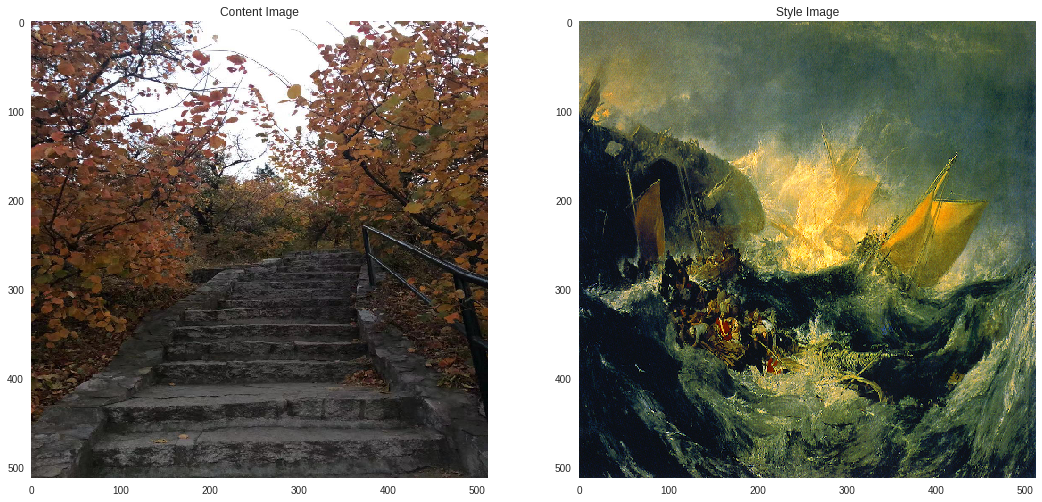

In [0]:
import matplotlib.pyplot as plt

def show_img(img_arr, title):
  out_img = np.squeeze(img_arr.astype('uint8'), axis=0)
  plt.title(title)
  plt.grid(False)
  plt.imshow(out_img)
  
plt.figure(figsize=(18, 9))
plt.subplot(1, 2, 1)
show_img(content_image, "Content Image")
 
plt.subplot(1, 2, 2)
show_img(style_image, "Style Image")

In [0]:
def deprocess_img(processed_img): 
    processed_img[:, :, :, 0] -= 103.939
    processed_img[:, :, :, 1] -= 116.779
    processed_img[:, :, :, 2] -= 123.68
    processed_img_arr = processed_img[:, :, :, ::-1]
    return processed_img_arr
  
content_array = deprocess_img(content_image)
style_array = deprocess_img(style_image)
print("content_array.shape={}, style_array.shape={}.".format(content_array.shape, style_array.shape))

content_array.shape=(1, 512, 512, 3), style_array.shape=(1, 512, 512, 3).


In [0]:
from keras import backend
from keras.applications.vgg16 import VGG16

content_image = backend.variable(content_array)
style_image = backend.variable(style_array)

combination_image = backend.placeholder((1, height, width, 3))
input_tensor = backend.concatenate([content_image, style_image, combination_image], axis=0)

loss = backend.variable(0.)
content_weight = 0.05
style_weight = 5.0
total_variation_weight = 1.0

model = VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)
layers = dict([(layer.name, layer.output) for layer in model.layers])

feature_layers = ['block1_conv2', 'block2_conv2',
            'block3_conv3', 'block4_conv3',
            'block5_conv3']

for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1,:,:,:]
    combination_features = layer_features[2,:,:,:]
    sl = style_loss(style_features,combination_features)
    loss += (style_weight/len(feature_layers))*sl

In [0]:
def content_loss(content, combination):
    return backend.sum(backend.square(content - combination))

In [0]:
layer_features = layers['block2_conv2']
content_image_features = layer_features[0,:,:,:]
combination_features = layer_features[2,:,:,:]
loss += content_weight * content_loss(content_image_features, combination_features)

In [0]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x,(2,0,1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

In [0]:
def style_loss(style,combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    st = backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))
    return st

In [0]:
def total_variation_loss(x):
    a = backend.square(x[:,:height-1,:width-1,:]-x[:,1:,:width-1,:])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))
loss += total_variation_weight * total_variation_loss(combination_image)

In [0]:
grads = backend.gradients(loss, combination_image)

In [0]:
outputs=[loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)
f_outputs = backend.function([combination_image], outputs)

In [0]:
def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

In [0]:
class Evaluator(object):
    def __init__(self):
        self.loss_value=None
        self.grads_values=None
    
    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

In [0]:
import time
from scipy.optimize import fmin_l_bfgs_b

def generate():
    x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.0
    evaluator = Evaluator()
    
    iterations = 10
    for i in range(iterations):
        print('Iteration {}'.format(i + 1))
        start_time = time.time()
        x, min_val, info = fmin_l_bfgs_b(evaluator.loss, 
                                         x.flatten(),
                                         fprime=evaluator.grads, 
                                         maxfun=20)
        print(min_val)
        end_time = time.time()
        print('Iteration {} 在{:.2f}秒完成'.format(i, end_time - start_time))
    return x
        
img_x = generate()

Iteration 1
47021440000.0
Iteration 0 在15.87秒完成
Iteration 2
28353214000.0
Iteration 1 在14.39秒完成
Iteration 3
22977868000.0
Iteration 2 在14.67秒完成
Iteration 4
21185898000.0
Iteration 3 在14.72秒完成
Iteration 5
20258804000.0
Iteration 4 在15.55秒完成
Iteration 6
19428456000.0
Iteration 5 在15.49秒完成
Iteration 7
18854175000.0
Iteration 6 在15.42秒完成
Iteration 8
18459642000.0
Iteration 7 在15.11秒完成
Iteration 9
18183066000.0
Iteration 8 在14.87秒完成
Iteration 10
18011770000.0
Iteration 9 在14.77秒完成


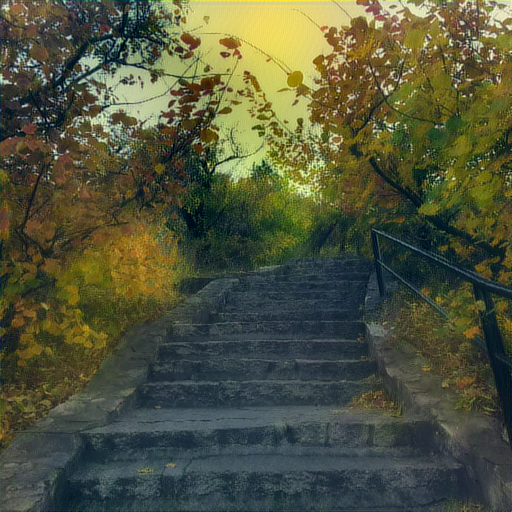

In [0]:
def output_process_img(img_arr):
    img_arr = img_arr.reshape((height, width, 3))
    img_arr = img_arr[:, :, ::-1]
    img_arr[:, :, 0] += 103.939
    img_arr[:, :, 1] += 116.779
    img_arr[:, :, 2] += 123.68
    img_arr = np.clip(img_arr, 0, 255).astype('uint8')
    return img_arr
    
x = output_process_img(img_x)
Image.fromarray(x)